In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import cv2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
from sklearn.naive_bayes import ComplementNB
# import tensorflow as tf
import imblearn
from imblearn.over_sampling import SMOTE
stopwords = text.ENGLISH_STOP_WORDS

In [2]:
data = pd.read_csv("data_race_pred.csv")
data[:5]

,Unnamed: 0,id,tweets,name,screen_name,description,img_path,is_female,year_born,race
0,0,12488,"['YKAR, a futuristic sans serif font by @Emmer...",Chad Boyce,djsnipa1,"Multimedia Developer, Graphic Designer, DJ, an...",profile pics/60147.jpeg,0.0,1980.0,4.0
1,1,719703,"['In other words, it’s good news about the vac...",Tomato 😷,Tomato,🇭🇰Rise Up!,profile pics/60148.jpeg,0.0,1985.0,4.0
2,2,749003,['would it be fair to call lil nas x the first...,A ring made from a spoon --- E83.31,IYQbd,Has the kind of luck that turns a professional...,profile pics/60150.jpeg,0.0,1982.0,5.0
3,3,822540,"['@Asmongold ❤️ 🙏', '@Hunter4J @Wario64 bonk',...",parker,parker,gotta go fast,profile pics/60153.jpeg,0.0,1979.0,4.0
4,4,865071,['@robo_james How about pizza dipped in water ...,Kevin Jones,kevinj,NaN,profile pics/60154.jpeg,0.0,1995.0,4.0


In [3]:
def preprocess(data):
    t = data
    t = t.lower() # lower letters
    t = re.sub(r'http\S+', '', t) # remove HTTP links
    t = re.sub(r'@[^\s]+', '', t) # remove usernames
    t = re.sub(r'#[^\s]+', '', t) # remove hashtags
    t = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', t)
    t = re.sub(r'[^\w\s\?]', '', t) # remove punctuations except ?
    t = ' '.join([word for word in t.split() if word not in stopwords]) # remove stopwords
    return t

In [4]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
data["race"] = data["race"].astype(int)
data = data.drop(data[data["race"] == 5].index)
data["tweets"] = data["tweets"].apply(preprocess)
data[:5]

,Unnamed: 0,id,tweets,name,screen_name,description,img_path,is_female,year_born,race
0,0,12488,ykar futuristic sans serif font contact rude p...,Chad Boyce,djsnipa1,"Multimedia Developer, Graphic Designer, DJ, an...",profile pics/60147.jpeg,0.0,1980.0,4
1,1,719703,words good news vaccines safety media misrepre...,Tomato 😷,Tomato,🇭🇰Rise Up!,profile pics/60148.jpeg,0.0,1985.0,4
3,3,822540,bonk nice ed mcboy oos getting real tired game...,parker,parker,gotta go fast,profile pics/60153.jpeg,0.0,1979.0,4
7,7,1143891,piano transcription adagietto mahler 5th littl...,Ian Hsu,IanHsu,"Proud papa, intrepid explorer, loves slow-cook...",profile pics/60157.jpeg,0.0,1976.0,3
8,8,1191741,tell em n n levar burton longer interested hos...,~JOSh-X,lightmanx5,if BlackLives.Matter then AllLives.Matter = T;...,profile pics/60158.jpeg,0.0,1973.0,4


In [5]:
data["race"].value_counts()

4    1889
1     236
2     153
3      75
Name: race, dtype: int64

# Try Muiltiple Models

In [6]:
tfidf = TfidfVectorizer(max_features = 7500, ngram_range=(1,2))
X = tfidf.fit_transform(data['tweets'])
y = data['race']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4.0, random_state=0)

In [7]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

y_pred = [round(x) for x in y_pred] 
for index in range(len(y_pred)): 
    if y_pred[index] < 1:
        y_pred[index] = 1
    if y_pred[index] > 4:
        y_pred[index] = 4

print(set(y_pred))

{1, 2, 3, 4}


              precision    recall  f1-score   support

           1       0.33      0.04      0.06        57
           2       0.18      0.29      0.22        35
           3       0.04      0.40      0.07        20
           4       0.89      0.59      0.71       477

    accuracy                           0.51       589
   macro avg       0.36      0.33      0.27       589
weighted avg       0.77      0.51      0.60       589

RMSE on testing set =  1.0305602716468591


<AxesSubplot:>

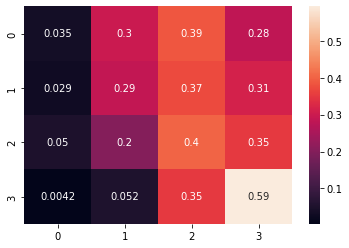

In [8]:
print(classification_report(y_test, y_pred))

print("RMSE on testing set = ", mean_squared_error(y_test, y_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)

In [9]:
log = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)
y_pred = log.predict(X_test)

y_pred = [round(x) for x in y_pred] 
for index in range(len(y_pred)): 
    if y_pred[index] < 1:
        y_pred[index] = 1
    if y_pred[index] > 4:
        y_pred[index] = 4

print(set(y_pred))

{1, 4}


              precision    recall  f1-score   support

           1       0.75      0.05      0.10        57
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        20
           4       0.82      1.00      0.90       477

    accuracy                           0.81       589
   macro avg       0.39      0.26      0.25       589
weighted avg       0.73      0.81      0.74       589

RMSE on testing set =  1.0916808149405772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

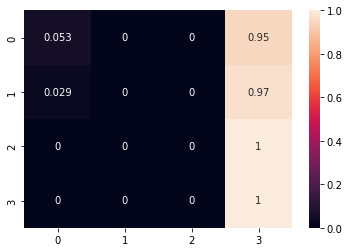

In [10]:
print(classification_report(y_test, y_pred))

print("RMSE on testing set = ", mean_squared_error(y_test, y_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)

In [11]:
set(y_test) - set(y_pred)

{2, 3}

In [12]:
# naive Bayes
clf = ComplementNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_pred = [round(x) for x in y_pred] 
for index in range(len(y_pred)): 
    if y_pred[index] < 1:
        y_pred[index] = 1
    if y_pred[index] > 4:
        y_pred[index] = 4

              precision    recall  f1-score   support

           1       0.37      0.12      0.18        57
           2       0.06      0.03      0.04        35
           3       0.10      0.10      0.10        20
           4       0.82      0.91      0.86       477

    accuracy                           0.76       589
   macro avg       0.34      0.29      0.30       589
weighted avg       0.71      0.76      0.72       589

RMSE on testing set =  1.2648556876061121


<AxesSubplot:>

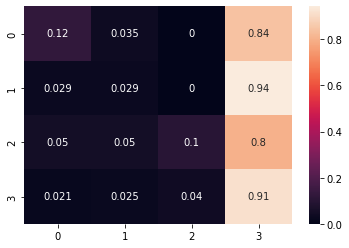

In [13]:
print(classification_report(y_test, y_pred))

print("RMSE on testing set = ", mean_squared_error(y_test, y_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)

# Apply Oversampling

In [14]:
X = tfidf.fit_transform(data['tweets'])
y = data['race']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4.0, random_state=0)

In [15]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(y_train.value_counts())
log = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)
y_pred = log.predict(X_test)

4    1412
2    1412
1    1412
3    1412
Name: race, dtype: int64


In [16]:
y_pred = [round(x) for x in y_pred] 
for index in range(len(y_pred)): 
    if y_pred[index] < 1:
        y_pred[index] = 1
    if y_pred[index] > 4:
        y_pred[index] = 4

              precision    recall  f1-score   support

           1       0.39      0.49      0.44        57
           2       0.28      0.20      0.23        35
           3       0.00      0.00      0.00        20
           4       0.87      0.90      0.89       477

    accuracy                           0.79       589
   macro avg       0.39      0.40      0.39       589
weighted avg       0.76      0.79      0.77       589

RMSE on testing set =  1.2359932088285228


<AxesSubplot:>

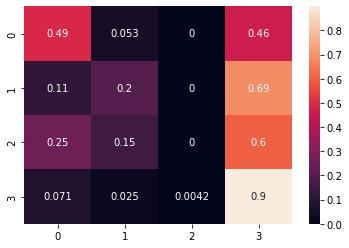

In [17]:
print(classification_report(y_test, y_pred))
print("RMSE on testing set = ", mean_squared_error(y_test, y_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           1       0.35      0.53      0.42        57
           2       0.20      0.23      0.21        35
           3       0.12      0.20      0.15        20
           4       0.88      0.79      0.84       477

    accuracy                           0.71       589
   macro avg       0.39      0.44      0.40       589
weighted avg       0.76      0.71      0.73       589

RMSE on testing set =  1.4855687606112054


<AxesSubplot:>

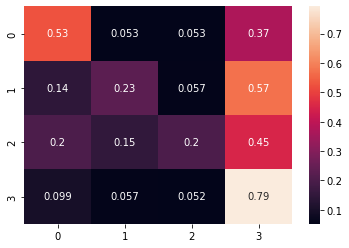

In [18]:
# naive Bayes
clf = ComplementNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_pred = [round(x) for x in y_pred] 
for index in range(len(y_pred)): 
    if y_pred[index] < 1:
        y_pred[index] = 1
    if y_pred[index] > 4:
        y_pred[index] = 4

print(classification_report(y_test, y_pred))
print("RMSE on testing set = ", mean_squared_error(y_test, y_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)